In [32]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer, PolynomialFeatures
import optuna
from optuna.samplers import TPESampler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge

QT = True # True if wish to implement quartile transformation to data
BASIC = True # True if wish to use basic hyperparameters for models
RANDOM = 42
TUNE = False # Whether to tune hyperparameters or not

<p style="text-align:center; font-size:30px; font-family:cursive;"> Welcome to PS_S3_Ep11 Challenge </p>

#### Here we are again!
#### This time, it is a regression challenge and the metric being Root Mean Squared Log Error.
#### Let's jump right in!

# Data

In [33]:
train = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv')
original = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')

# Concatenate the training and original training dataset
total_train = pd.concat([train, original])
total_train.drop_duplicates(inplace=True)
total_train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [34]:
total_train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51358,3.70,2.0,4.0,4.0,1.0,10.40,1.0,1.0,18.0,34452.0,1.0,0.0,0.0,0.0,1.0,147.17
51359,10.36,4.0,2.0,0.0,2.0,9.43,0.0,0.0,20.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
51360,11.19,3.0,3.0,0.0,3.0,18.50,0.0,0.0,5.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
51361,3.78,3.0,1.0,1.0,2.0,19.80,0.0,1.0,8.0,23598.0,0.0,0.0,0.0,0.0,1.0,135.92


In [35]:
# Define our feature and target variables
features = list(total_train.columns[:-1])
target = 'cost'

#### Let's try to visualize our data first.

## Data Visualization

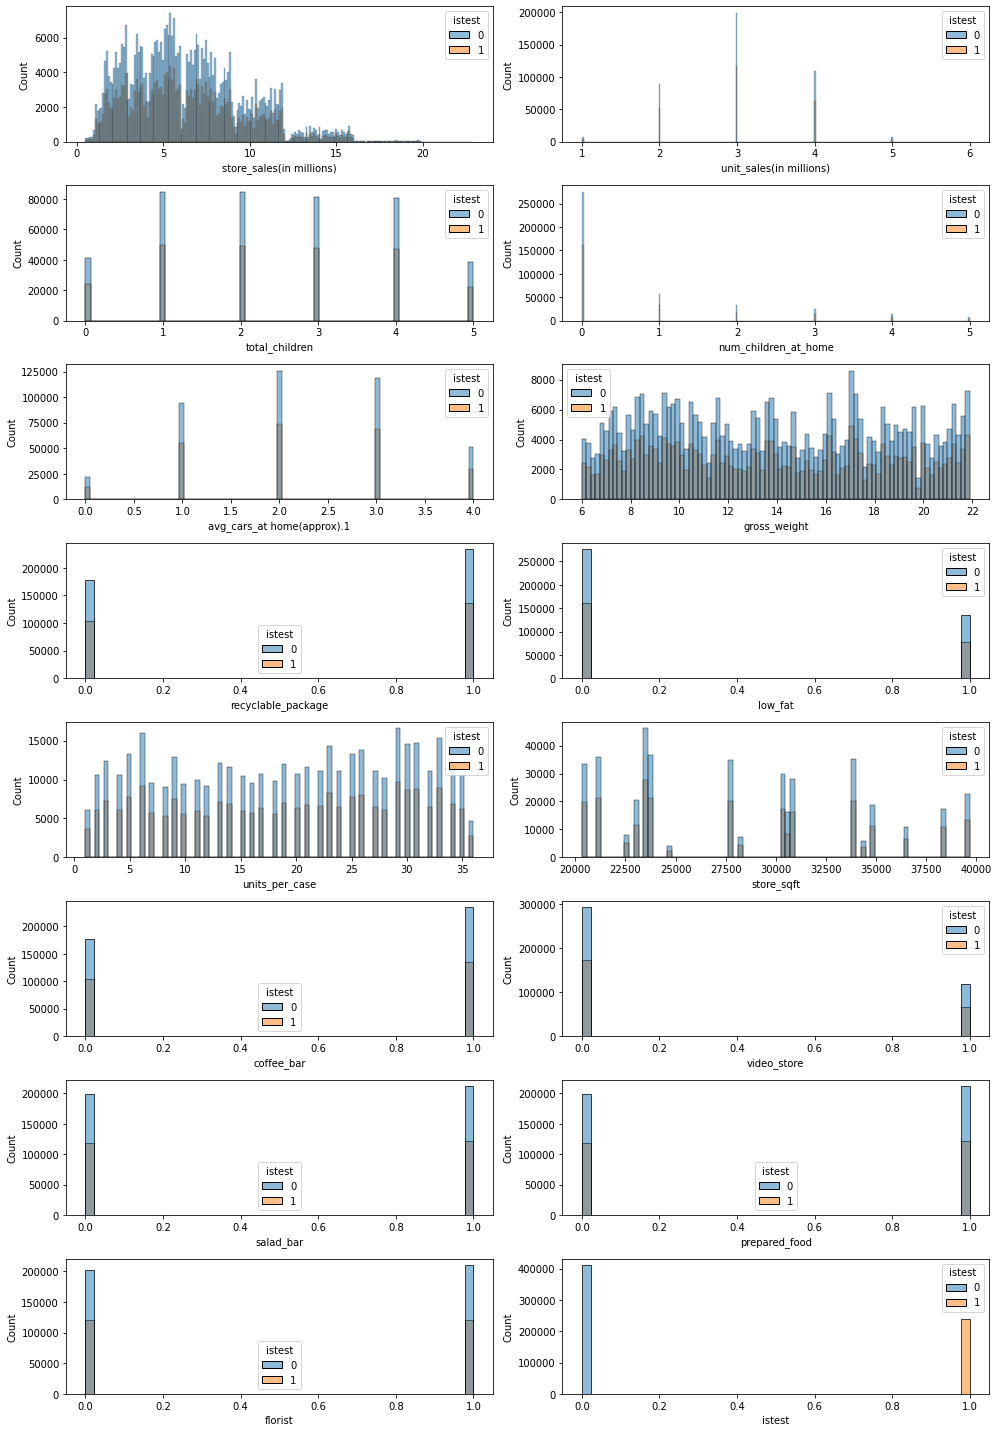

In [36]:
rows, cols = 8, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### As we can see, even though all of the features are numerical data, some of them are in fact categorical features.
#### However since they are already in numerical figures, we would just need to take care of scaling in order to feed them to scale sensitive models.

## Data Scaling

#### Before we scale the data, observe it once more.
#### The one problem we can observe is the skewedness of the store sales.
#### Let's see if we can apply the quantile transformation to it.

In [37]:
# total_train and test dataframes will have to be scaled using the min-max scaler 
scaler = MinMaxScaler()
qt = QuantileTransformer()

total_train['istest'] = 0
test['istest'] = 1

# Let's concat them to prepare them for scaling
temp = pd.concat([total_train, test]).copy()
temp[features] = scaler.fit_transform(temp[features])
if QT:
    temp['store_sales(in millions)'] = qt.fit_transform(np.array(temp['store_sales(in millions)']).reshape(-1,1))

train_scaled = temp[temp['istest'] == 0]
test_scaled = temp[temp['istest'] == 1]

# Drop the istest column
train_scaled.drop(['istest'], axis=1, inplace=True)
test_scaled.drop(['istest'], axis=1, inplace=True)
total_train.drop(['istest'], axis=1, inplace=True)
test.drop(['istest'], axis=1, inplace=True)

#### Let's visualize what our scaled data looks like.

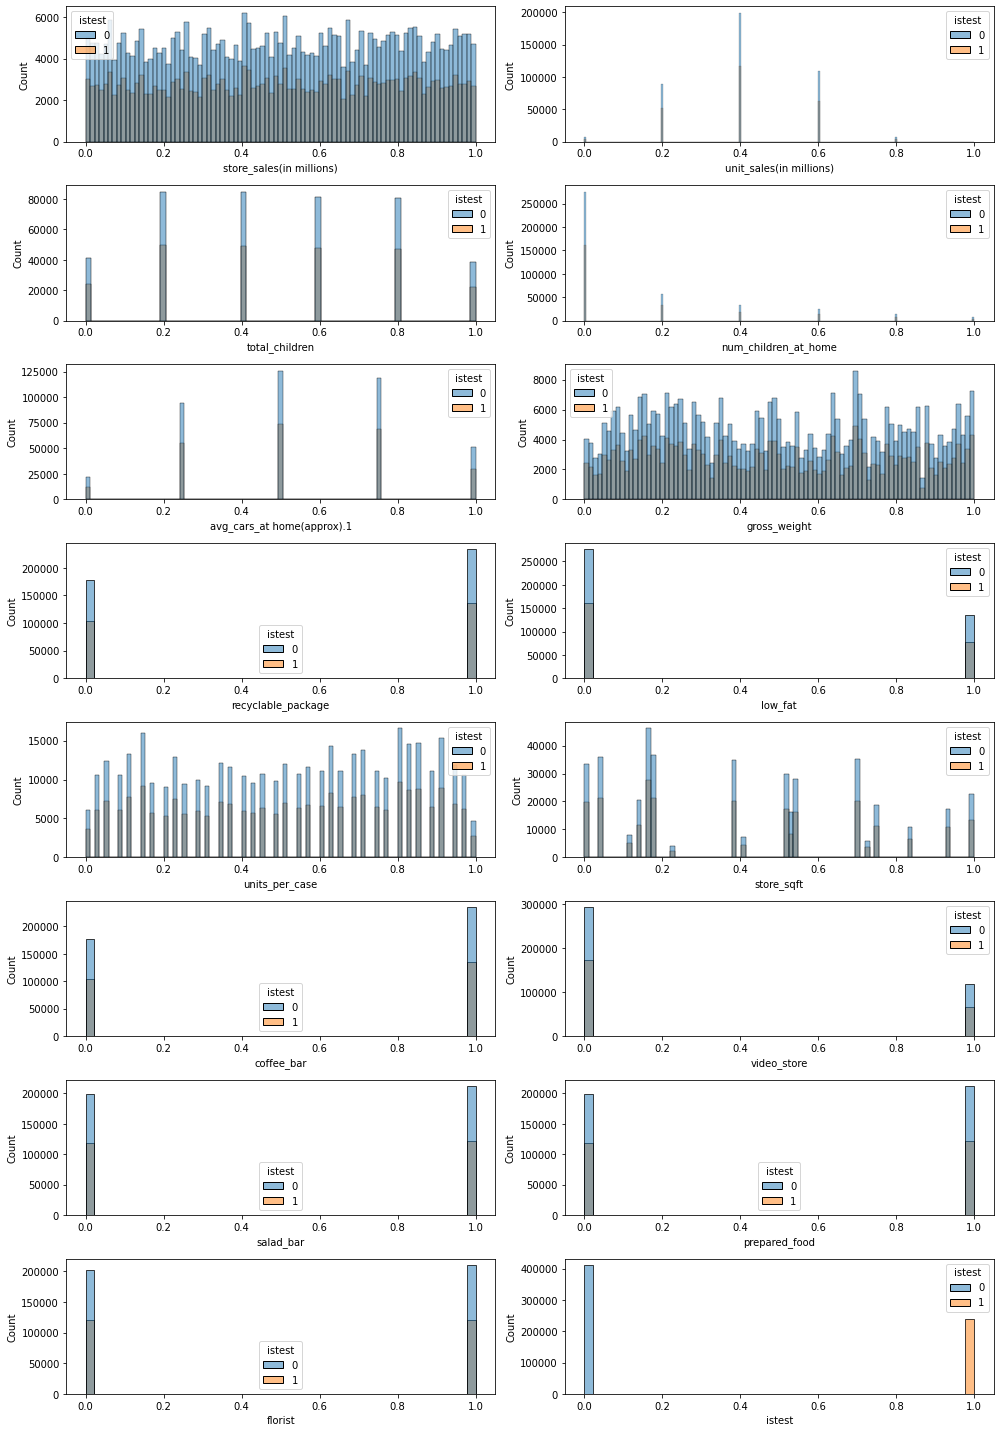

In [38]:
rows, cols = 8, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
train_scaled['istest'] = 0
test_scaled['istest'] = 1
features.extend(['istest'])
raw = pd.concat([train_scaled, test_scaled])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### Just as we expected!
#### Scaling has been performed and left skewedness of data has been fixed.

# Modeling

#### Let's define our X and y variables first.

In [39]:
X = total_train[features]
y = total_train[target]

X_scaled = train_scaled[features]
y_scaled = train_scaled[target]

scores = {}

## XGBRegressor

In [40]:
if BASIC:
    xgb_params = {
        'verbosity' : 0,
        'tree_method': 'gpu_hist',
        'random_state': RANDOM,
    }

else: 
    xgb_params = {'max_depth': 4, 
                  'learning_rate': 0.09611818583558296, 
                  'n_estimators': 270, 
                  'min_child_weight': 5, 
                  'gamma': 0.28475464776988313, 
                  'subsample': 0.9134512574147342, 
                  'colsample_bytree': 0.3787011404635416, 
                  'reg_alpha': 0.6415802448962679, 
                  'reg_lambda': 0.1986109971071448,
                  'verbosity': 0,
                  'tree_method': 'gpu_hist',
                  'random_state': RANDOM,}
    
xgbr = XGBRegressor(**xgb_params)
scores['XGB'] = np.mean((cross_val_score(xgbr, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['XGB'])

0.30276405529583417


## CatBoostRegressor

In [41]:
if BASIC:
    catboost_params = {
        'verbose' : False,
        'task_type':"GPU",
        'random_state': RANDOM,
    }
else:
    catboost_params = {'iterations': 739, 
                       'learning_rate': 0.20343252867548206, 
                       'depth': 4, 
                       'l2_leaf_reg': 36.66494999011264, 
                       'bootstrap_type': 'Bayesian', 
                       'random_strength': 42.140339799438195, 
                       'bagging_temperature': 7.250462648914117, 
                       'od_type': 'Iter', 
                       'od_wait': 37,
                       'verbose': False,
                       'task_type':"GPU",
                       'random_state': RANDOM,}

catboost = CatBoostRegressor(**catboost_params)
scores['catboost'] = np.mean((cross_val_score(catboost, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['catboost'])

0.30305191327851483


## LGMBRegressor

In [42]:
if BASIC:
    lgbm_params = {
        'verbose' : -1,
        #'device':'gpu',
        'random_state': RANDOM,
    }

else:
    lgbm_params = {'boosting_type': 'gbdt', 
                   'num_leaves': 97, 
                   'learning_rate': 0.019299497033284117, 
                   'n_estimators': 938, 
                   'max_depth': 7, 
                   'min_child_samples': 183, 
                   'subsample': 0.7510503722144701, 
                   'colsample_bytree': 0.6291255251801097, 
                   'reg_alpha': 0.40274561975696616, 
                   'reg_lambda': 0.6655461171405869,
                   'device':'gpu',
                   'random_state': RANDOM,}

lgbm = LGBMRegressor(**lgbm_params)
scores['lgbm'] = np.mean((cross_val_score(lgbm, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['lgbm'])

0.3039320169709334


## HistGradientBoostingRegressor

In [43]:
hr = HistGradientBoostingRegressor()
scores['hr'] = np.mean((cross_val_score(hr, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['hr'])

0.3038408091147042


## Linear Regression

In [44]:
lr = LinearRegression()
scores['lr'] = np.mean((cross_val_score(lr, X_scaled, y_scaled, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['lr'])

0.3172499834193277


## Lasso

In [45]:
lasso = Lasso()
scores['lasso'] = np.mean((cross_val_score(lasso, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['lasso'])

0.3186944454864608


## ElasticNet

In [46]:
en = ElasticNet()
scores['en'] = np.mean((cross_val_score(en, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['en'])

0.3187787881477676


## Ridge

In [47]:
ridge = Ridge()
scores['ridge'] = np.mean((cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['ridge'])

0.3172491570757621


#### Let's take a look at the scores for all our models.

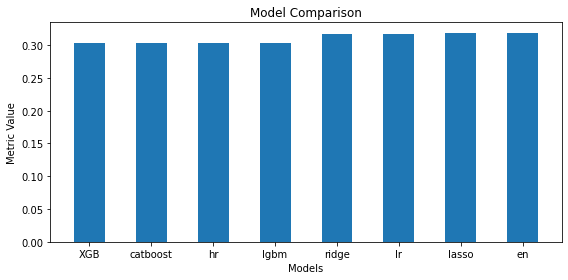

In [48]:
fig = plt.figure(figsize = (8,4))
scores = dict(sorted(scores.items(), key=lambda item: item[1]))
# creating the bar plot
plt.bar(scores.keys(), scores.values(), width = 0.5)
 
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison")
plt.tight_layout()
plt.show()

#### As usual, it turns out the tree-based models were the best performing.
#### Let's try to introduce some [polynomial features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to these models.

In [49]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_scaled_poly = poly.fit_transform(X_scaled)

## XGBRegressor with Polynomial features

In [50]:
if BASIC:
    xgb_params = {
        'verbosity' : 0,
        'tree_method': 'gpu_hist',
        'random_state': RANDOM,
    }

else: 
    xgb_params = {'max_depth': 9, 
                  'learning_rate': 0.034324453515020704, 
                  'min_child_weight': 8, 
                  'gamma': 0.6345671609060867, 
                  'reg_alpha': 0.3967034663248523, 
                  'reg_lambda': 0.9327347082052488,
                  'tree_method': 'gpu_hist',
                  'random_state': RANDOM,}
    
xgbr_poly = XGBRegressor(**xgb_params)
scores['XGB_poly'] = np.mean((cross_val_score(xgbr_poly, X_poly, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['XGB_poly'])

0.30144790481814226


## CatBoostRegressor with Polynomial features

In [52]:
if BASIC:
    catboost_params = {
        'verbose' : False,
        'task_type':"GPU",
        'random_state': RANDOM,
    }
else:
    catboost_params = {'iterations': 271, 
                        'learning_rate': 0.23237140898709763, 
                        'depth': 8, 
                        'l2_leaf_reg': 0.0004664457151119415,
                       'verbose': False,
                       'task_type':"GPU",
                       'random_state': RANDOM,}

catboost_poly = CatBoostRegressor(**catboost_params)
scores['catboost_poly'] = np.mean((cross_val_score(catboost_poly, X_poly, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['catboost_poly'])

0.3016969679372094


## Lasso with Polynomial features

In [53]:
lasso_poly = Lasso()
scores['lasso_poly'] = np.mean((cross_val_score(lasso_poly, X_scaled_poly, y_scaled, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['lasso_poly'])

0.3191463310180832


## Linear Regression with Polynomial features

In [54]:
lr_poly = LinearRegression()
scores['lr_poly'] = np.mean((cross_val_score(lr_poly, X_scaled_poly, y_scaled, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['lr_poly'])

0.31666808501100807


#### I would say XGBoost and CatBoost performed pretty good with the polynomial features but the linear models did not live up to my expectations.
#### Now that we know which models perform best, let us tune their hyperparameters 

# Hyperparameter Tuning

#### Let's tune for XGBoost first.

In [55]:
def objective(trial):   
    params_xgb = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        #'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        # 'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        "tree_method":"gpu_hist",
        'random_state': RANDOM,
        }

    xgb_tuned = XGBRegressor(**params_xgb)
    return np.mean((cross_val_score(xgb_tuned, X_poly, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)

if TUNE:
    xgb_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    optuna.logging.set_verbosity(optuna.logging.INFO)
    xgb_tuning.optimize(func=objective, n_trials=70)
    print(xgb_tuning.best_params)

#### Let's now tune for CatBoostRegressor.

In [56]:
def objective(trial): 
    
    params_optuna = {
        'iterations':trial.suggest_int("iterations", 100, 1000),
        'learning_rate' : trial.suggest_float('learning_rate',0.01, 1),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        #'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        #'random_strength': trial.suggest_float('random_strength',10,50),
        #'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        #'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        #'od_wait':trial.suggest_int("od_wait", 10, 50),
        'verbose':False,
        'task_type' : 'GPU',
        'random_state': RANDOM,
    }

    catboost_tuned = CatBoostRegressor(**params_optuna)
    return np.mean((cross_val_score(catboost_tuned, X_poly, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)

if TUNE:
    catboost_tuning = optuna.create_study(direction='minimize', sampler = TPESampler())
    optuna.logging.set_verbosity(optuna.logging.INFO)
    catboost_tuning.optimize(func=objective, n_trials=50)
    print(catboost_tuning.best_params)

#### Now that we have the optimized hyperparameters, let us observe how well they perform.

In [57]:
xgb_params = {'max_depth': 9, 
              'learning_rate': 0.034324453515020704, 
              'min_child_weight': 8, 
              'gamma': 0.6345671609060867, 
              'reg_alpha': 0.3967034663248523, 
              'reg_lambda': 0.9327347082052488,
              'tree_method': 'gpu_hist',
              'random_state': RANDOM,}
    
xgbr_poly_tuned = XGBRegressor(**xgb_params)
scores['XGB_poly_tuned'] = np.mean((cross_val_score(xgbr_poly_tuned, X_poly, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['XGB_poly_tuned'])

0.29801620583823113


In [58]:
catboost_params = {'iterations': 271, 
                    'learning_rate': 0.23237140898709763, 
                    'depth': 8, 
                    'l2_leaf_reg': 0.0004664457151119415,
                    'verbose': False,
                    'task_type':"GPU",
                    'random_state': RANDOM}

catboost_poly_tuned = CatBoostRegressor(**catboost_params)
scores['catboost_poly_tuned'] = np.mean((cross_val_score(catboost_poly_tuned, X_poly, y, cv=5, scoring='neg_mean_squared_log_error'))*-1)**(1/2)
print(scores['catboost_poly_tuned'])

0.3017999668278737


#### Seems like there has been some improvements!
#### Now let us see whether we can find the proper weights for them to submit the ensembled version of these models.
#### Before that, we would need to make predictions on the training sets first.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.33, random_state=42)

xgbr_poly_tuned.fit(X_train, y_train)
catboost_poly_tuned.fit(X_train,y_train)

xgbr_pred = xgbr_poly_tuned.predict(X_test)
catboost_pred = catboost_poly_tuned.predict(X_test)


In [60]:
# range of weights
weights = np.arange(0.01, 1.01, 0.01)

# Initialize variables to keep track of best weights and loss
ensamble_weights = None
best_loss = np.inf

# Loop through all possible weight combinations
for a in tqdm(weights):
  b = 1-a
  if b > 0:
    y_pred = a * xgbr_pred + b * catboost_pred 
    loss = mean_squared_log_error(y_test, y_pred, squared=False)
  if loss < best_loss:
    ensamble_weights = (a.round(2), b.round(2))
    best_loss = loss

print(f"Best weights: {ensamble_weights}")
print(f"Best loss: {best_loss: .6f}")

100%|██████████| 100/100 [00:00<00:00, 173.32it/s]

Best weights: (0.99, 0.01)

Best loss:  0.298190


#### Well, it seems like the XGBRegressor model did really well.
#### Let us try to submit with the weight above.

In [61]:
xgbr_poly_tuned.fit(X_poly, y)
catboost_poly_tuned.fit(X_poly, y)

X_poly_test = poly.fit_transform(test[features])

xgbr_pred = xgbr_poly_tuned.predict(X_poly_test)
catboost_pred = catboost_poly_tuned.predict(X_poly_test)

sample['cost'] = 0.99 * xgbr_pred + 0.01 * catboost_pred

sample.to_csv('submission.csv', index=False)